In [1]:
import h5py
import numpy as np
import matlab.engine
import sys
import matplotlib.pyplot as plt
import math
import torch

import size_transforms as size_T


In [2]:
eng = matlab.engine.start_matlab()

In [3]:
#create list of files

file_prefixes = ["g4","g5","g7","g8",
                 "p4","p6","p8","p10",
                 "s1","s3","s5","s8"]

filenames = []
for prefix in file_prefixes:
    for i in range(1,13):
        filenames+=[f"{prefix}_s{i:02d}"]

output_folder = "C:/Users/rodrigo/Documents/gaba_edited_mrs_acceleration/data/indiv_specreg"

In [10]:
for step,filename in enumerate(filenames):

    mrs_struct = eng.load(f"c:/Users/rodrigo/Documents/thesis/data/gannet_acc_load/{filename}.mat")["mrs_struct"]

    print(mrs_struct["out"].keys())

    specreg_freq = np.array(mrs_struct["out"]['SpecReg']["freq"])
    specreg_phase = np.array(mrs_struct["out"]['SpecReg']["phase"])

    print(specreg_freq)
    print(specreg_phase)

    break

dict_keys(['AvgDeltaF0', 'SpecReg', 'reject'])
[[[1.28442442 1.3127112  1.44076418 1.24753244 1.76784071 1.16696546
   1.283795   1.30363447 1.33700657 1.70184746 1.18085269 0.93659613
   0.71704866 0.63845174 1.23118878 0.95290774 1.7081193  1.42654776
   1.66784895 1.94062047 1.32730852 1.90992939 1.28738977 1.78642109
   1.4155122  1.49220669 1.51594646 1.21409828 1.59153035 1.06853401
   1.21003696 1.24156485 1.0385716  1.54741283 1.02989425 1.37060263
   1.2169023  0.97196163 1.13549965 1.40963027 1.13812177 1.65755447
   1.12938577 1.1763699  1.22867442 1.01891206 1.32039237 0.95524326
   1.53077547 1.08188038 1.46844399 1.00115583 1.32919676 1.00524347
   1.14598044 1.07694543 0.85181519 1.25072138 0.88337336 1.28931534
   1.00260392 1.24328287 0.88263524 1.2021277  0.94227723 1.39360207
   0.96782997 1.01907147 1.14998272 0.87519792 1.2655723  0.94349989
   1.59532013 1.13061909 1.31289865 0.98050639 1.24519481 0.62787018
   0.83897262 0.94986639]]]
[[[ 3.18106535  4.25619581  

In [12]:
quickstart = 0

for step,filename in enumerate(filenames):
    if step<quickstart:
        continue

    mrs_struct_target = eng.load(f"c:/Users/rodrigo/Documents/thesis/data/gannet_full_load/{filename}.mat")["mrs_struct"]

    struct_freq = torch.from_numpy(np.array(mrs_struct_target["spec"]["freq"]))[0]

    target = size_T.spec_resampling_1d(torch.from_numpy(np.array(mrs_struct_target["spec"]["vox1"]["GABAGlx"]["diff"])[0]),struct_freq,size_T.ref_freq_short)
    target_on = size_T.spec_resampling_1d(torch.from_numpy(np.array(mrs_struct_target["spec"]["vox1"]["GABAGlx"]["on"])[0]),struct_freq,size_T.ref_freq_short)
    target_off = size_T.spec_resampling_1d(torch.from_numpy(np.array(mrs_struct_target["spec"]["vox1"]["GABAGlx"]["off"])[0]),struct_freq,size_T.ref_freq_short)

    del mrs_struct_target

    mrs_struct_acc = eng.load(f"c:/Users/rodrigo/Documents/thesis/data/gannet_acc_load/{filename}.mat")["mrs_struct"]

    specs = torch.from_numpy(np.array(mrs_struct_acc["spec"]["AllFramesFTrealign"]))
    transients_specs_on_off = size_T.spec_resampling(specs,struct_freq,size_T.ref_freq_short)
    
    on_off = torch.from_numpy(np.array(mrs_struct_acc["fids"]["ON_OFF"]))[0]

    transient_specs = torch.zeros(size=(transients_specs_on_off.shape[0],2,transients_specs_on_off.shape[1]//2),dtype=transients_specs_on_off.dtype)


    on_counter=0
    off_counter=0
    for i in range(on_off.shape[0]):
        if on_off[i]==0:
            transient_specs[:,0,off_counter]=transients_specs_on_off[:,i]
            off_counter+=1
        elif on_off[i]==1:
            transient_specs[:,1,on_counter]=transients_specs_on_off[:,i]
            on_counter+=1
        else:
            raise Exception("on off error")
        
    with h5py.File(f"{output_folder}/{filename}.h5","w") as hf:
        hf.create_dataset("transient_specs",data=transient_specs)
        hf.create_dataset("ppm",data=size_T.ref_freq_short)
        hf.create_dataset("target",data=target)
        hf.create_dataset("target_off",data=target_off)
        hf.create_dataset("target_on",data=target_on)

    #break

    print(f"{step+1}/{len(filenames)} - {filename}")

1/144 - g4_s01
2/144 - g4_s02
3/144 - g4_s03
4/144 - g4_s04
5/144 - g4_s05
6/144 - g4_s06
7/144 - g4_s07
8/144 - g4_s08
9/144 - g4_s09
10/144 - g4_s10
11/144 - g4_s11
12/144 - g4_s12
13/144 - g5_s01
14/144 - g5_s02
15/144 - g5_s03
16/144 - g5_s04
17/144 - g5_s05
18/144 - g5_s06
19/144 - g5_s07
20/144 - g5_s08
21/144 - g5_s09
22/144 - g5_s10
23/144 - g5_s11
24/144 - g5_s12
25/144 - g7_s01
26/144 - g7_s02
27/144 - g7_s03
28/144 - g7_s04
29/144 - g7_s05
30/144 - g7_s06
31/144 - g7_s07
32/144 - g7_s08
33/144 - g7_s09
34/144 - g7_s10
35/144 - g7_s11
36/144 - g7_s12
37/144 - g8_s01
38/144 - g8_s02
39/144 - g8_s03
40/144 - g8_s04
41/144 - g8_s05
42/144 - g8_s06
43/144 - g8_s07
44/144 - g8_s08
45/144 - g8_s09
46/144 - g8_s10
47/144 - g8_s11
48/144 - g8_s12
49/144 - p4_s01
50/144 - p4_s02
51/144 - p4_s03
52/144 - p4_s04
53/144 - p4_s05
54/144 - p4_s06
55/144 - p4_s07
56/144 - p4_s08
57/144 - p4_s09
58/144 - p4_s10
59/144 - p4_s11
60/144 - p4_s12
61/144 - p6_s01
62/144 - p6_s02
63/144 - p6_s03
6

In [11]:
with h5py.File("indiv_specreg/g4_s01.h5") as hf:
    for key in hf:
        print(f"{key} - {hf[key][()].shape}")

ppm - (2048,)
target - (2048,)
target_off - (2048,)
target_on - (2048,)
transient_specs - (2048, 2, 40)


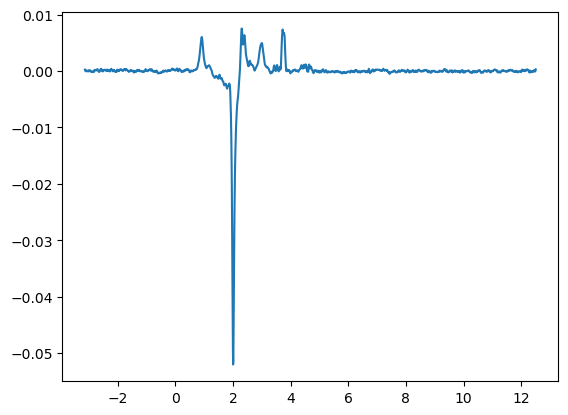

In [6]:
plt.plot(size_T.ref_freq_short,target)
#plt.plot(size_T.ref_freq_short,target_on)
#plt.plot(size_T.ref_freq_short,target_off)
plt.show()

c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\torch\_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


 ...]

Error in callback <function _draw_all_if_interactive at 0x00000274394051F0> (for post_execute):


KeyboardInterrupt: 

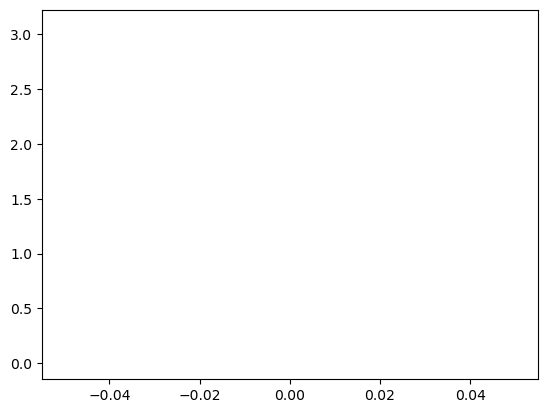

In [5]:
plt.plot(target_on)

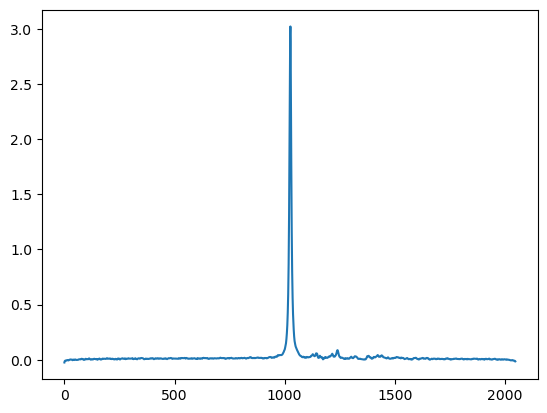

In [15]:
plt.plot(transient_specs[:,1,0])
plt.show()

In [ ]:
mrs_struct = eng.load("c:/Users/rodrigo/Documents/thesis/data/gannet_acc_load/g4_s01.mat")["mrs_struct"]
fid_data = torch.from_numpy(np.array(mrs_struct["fids"]["data"])[:,0])
sw = float(mrs_struct["p"]["sw"])
lb = float(mrs_struct["p"]["LB"])
larmor_freq = float(mrs_struct["p"]["LarmorFreq"])